<a href="https://colab.research.google.com/github/amr-elbana/AI-driven-post-harvest-sorting-system/blob/main/classification-Models/Augmented_Dataset_Models/Online_Augmented_Orange_classification_Vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import keras,os
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# **Global Varibales For pathes**

In [15]:
dataset_base_path = "/content/drive/MyDrive/Graduation Project/Dataset/Splitted dataset"  # Store the base path
model_save_path = "/content/drive/MyDrive/Graduation Project/Trained Models/VGG16_Model/_FineTuning_VGG16"
final_model_path = os.path.join(model_save_path, "Fine_Tuning_vgg16_best_model.keras")
history_file_path = os.path.join(model_save_path, "training_history.json")
results_save_path = os.path.join(model_save_path, "orange_vgg16_results.txt")
conf_matrix_save_path = os.path.join(model_save_path, "orange_vgg16_confusion_matrix.png")


# **DataSet**

In [16]:
# Define paths and constants
data_dir = os.path.join(dataset_base_path, "train-2")
val_dir = os.path.join(dataset_base_path, "validation")
test_dir = os.path.join(dataset_base_path, "test")
batch_size = 32
target_size = (224, 224)
epochs = 50

In [17]:
# Create an ImageDataGenerator with VGG16 preprocessing and data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG16-specific preprocessing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'     # Fill in missing pixels using the nearest neighbor
)

# Flow training data from the directory and apply preprocessing and augmentation
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=target_size,      # Resize images to VGG16 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)
    subset='training',            # Use 80% of data for training
    seed=42,                      # Set seed for reproducibility
    shuffle=True                  # Shuffle the data to improve training
)

# Create an ImageDataGenerator with VGG16 preprocessing and data augmentation
validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # VGG16-specific preprocessing
)

# Flow validation data from the directory and apply preprocessing (no augmentation for validation)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,      # Resize images to VGG16 input size
    batch_size=batch_size,
    class_mode='binary',          # Binary classification (healthy vs rotten)          # Use 20% of data for validation
    shuffle=False                 # No need to shuffle validation data
)

# ... (rest of the code remains the same)

# Check the number of samples in each generator
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Training batches per epoch: {len(train_generator)}")
print(f"Validation batches per epoch: {len(validation_generator)}")

Found 6368 images belonging to 2 classes.
Found 297 images belonging to 2 classes.
Training samples: 6368
Validation samples: 297
Training batches per epoch: 199
Validation batches per epoch: 10


In [18]:
# Create an ImageDataGenerator for VGG16 preprocessing (no augmentation for the test set)
test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input  # VGG16-specific preprocessing
)

# Flow data from the test directory and apply preprocessing
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # VGG16 input size
    batch_size=batch_size,
    class_mode='binary',     # Binary classification for the test set
    shuffle=False            # Do not shuffle test data to keep results consistent
)

# Check the number of samples in the test set
print(f"Test samples: {test_generator.samples}")
print(f"Test batches: {len(test_generator)}")

Found 373 images belonging to 2 classes.
Test samples: 373
Test batches: 12


# **Model Architecture**

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD

def create_model():
   # Load VGG16 model with pretrained weights, excluding the top (fully connected) layers
    vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Build the model
    model = Sequential()
    for layer in vgg16_base.layers:
       model.add(layer)

# Freeze the layers of VGG16 to retain the pre-trained weights
    for layer in model.layers[:-10]:
      layer.trainable = False # Not trainable weights

    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))  # L2 Regularization
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification

    model.summary()
    optimizer = SGD(learning_rate=0.0001, momentum=0.9)  # Lower learning rate
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])


    return model

# Create the model
model = create_model()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,203,521 (80.89 MB)

 Trainable params: 6,488,833 (24.75 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# **Training**

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Define callbacks
# checkpoint_path = "/content/drive/MyDrive/Models/overfit_vgg16_{epoch:02d}-{val_accuracy:0.2f}.keras"
checkpoint_path = os.path.join(model_save_path, "vgg16_{epoch:02d}-{val_accuracy:0.2f}.keras")
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor='val_accuracy',  # Save the best model based on validation accuracy
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping_monitor = EarlyStopping(
    monitor='val_loss',         # Focus on reducing overfitting
    patience=12,                # Allow enough time for gradual improvements
    restore_best_weights=True,  # Load the best weights after stopping
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',  # Adjust learning rate if validation loss doesn't improve
    factor=0.2,          # Reduce learning rate by a factor of 5
    patience=5,          # Wait 5 epochs before reducing


    min_lr=1e-6,         # Set a minimum learning rate
    verbose=1
)

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,  # Set a sufficiently high number; EarlyStopping will handle stopping
    callbacks=[checkpoint, early_stopping_monitor, reduce_lr]
)
# Save the final best model
model.save(final_model_path)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6729 - loss: 3.6219 
Epoch 1: val_accuracy improved from -inf to 0.89899, saving model to /content/drive/MyDrive/Models/overfit_vgg16_01-0.90.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 2458s 12s/step - accuracy: 0.6732 - loss: 3.6157 - val_accuracy: 0.8990 - val_loss: 1.0119 - learning_rate: 1.0000e-04
Epoch 2/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 821ms/step - accuracy: 0.8057 - loss: 1.3225
Epoch 2: val_accuracy improved from 0.89899 to 0.92593, saving model to /content/drive/MyDrive/Models/overfit_vgg16_02-0.93.keras
199/199 ━━━━━━━━━━━━━━━━━━━━ 203s 862ms/step - accuracy: 0.8058 - loss: 1.3222 - val_accuracy: 0.9259 - val_loss: 1.0102 - learning_rate: 1.0000e-04
Epoch 3/50
199/199 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - accuracy: 0.8441 - loss: 1.1372
Epoch 3: val_accuracy did not improve from 0.92593
199/199 ━━━━━━━━━━━━━━━━━━━━ 183s 893ms/step - accuracy: 0.8441 - loss: 1.1372 - val_accuracy: 0.9192 - val_loss: 0.9735 - learning_rate: 1.000

# **History Plotting**

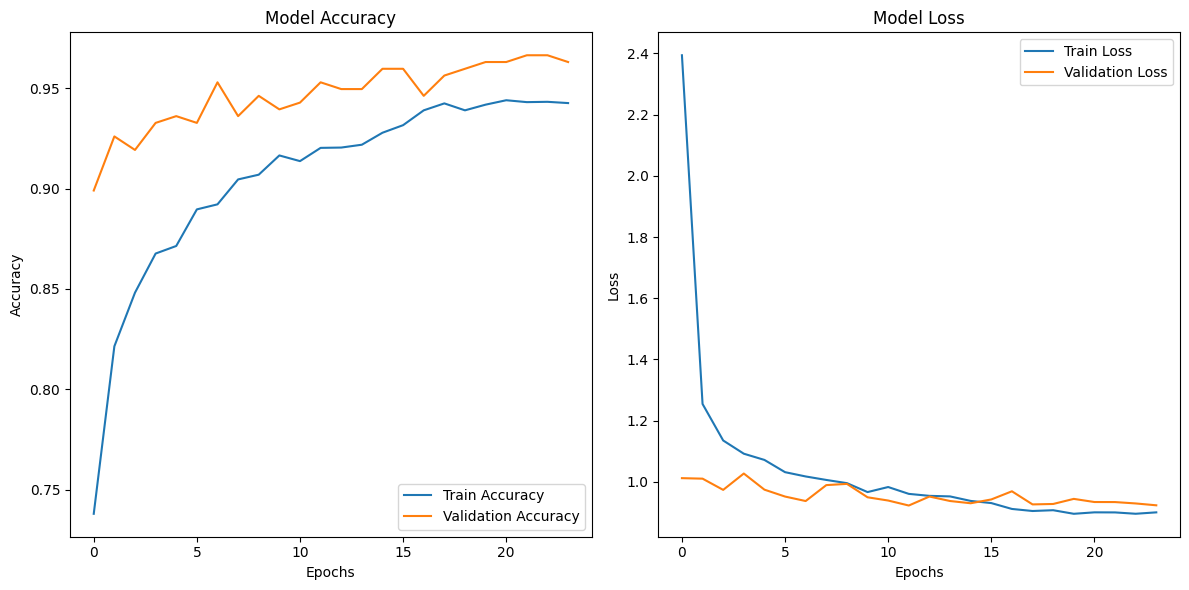

In [ ]:
import matplotlib.pyplot as plt

# Extract the training history
history = history.history

# Plot training & validation accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
final_train_acc = history['accuracy'][-1]
final_val_acc = history['val_accuracy'][-1]
final_train_loss = history['loss'][-1]
final_val_loss = history['val_loss'][-1]

print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")

Final Training Accuracy: 0.9425
Final Validation Accuracy: 0.9630
Final Training Loss: 0.9001
Final Validation Loss: 0.9231


In [ ]:
if 'lr' in history:  # Remove .history as 'history' is already a dictionary
    plt.plot(history['lr'], label='Learning Rate')
    plt.title('Learning Rate Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Learning Rate')
    plt.legend()
    plt.show()

In [ ]:
print(f"Training stopped at epoch: {len(history['loss'])}")

Training stopped at epoch: 24


# **History Saving**

In [ ]:
import json
import os  # Import the os module

history_file_path = os.path.join(model_save_path, "training_history.json")

# Save history to a JSON file on Google Drive
with open(history_file_path, "w") as f:
    json.dump(history, f)  # Use 'history' instead of 'History.history'

# Load the history later
with open(history_file_path, "r") as f:
    loaded_history = json.load(f)
    print(loaded_history)

{'accuracy': [0.7380653023719788, 0.8214510083198547, 0.8481469750404358, 0.8676193356513977, 0.8713881969451904, 0.8896042704582214, 0.8921168446540833, 0.9045225977897644, 0.9068781137466431, 0.9164572954177856, 0.9136306643486023, 0.9202261567115784, 0.9203831553459167, 0.9217965006828308, 0.927763819694519, 0.9315326809883118, 0.9389133453369141, 0.9423680901527405, 0.9389133453369141, 0.9417399764060974, 0.9439384341239929, 0.9429962038993835, 0.9431532621383667, 0.9425251483917236], 'loss': [2.394216299057007, 1.254382848739624, 1.1350229978561401, 1.0918036699295044, 1.0714586973190308, 1.0314427614212036, 1.0173994302749634, 1.006020426750183, 0.9955451488494873, 0.9663446545600891, 0.9828622341156006, 0.9604918360710144, 0.954020082950592, 0.9521933794021606, 0.9374510049819946, 0.9304066300392151, 0.91121906042099, 0.9044927954673767, 0.9070776700973511, 0.8953649401664734, 0.9001044631004333, 0.8998774290084839, 0.8954771161079407, 0.9000608921051025], 'val_accuracy': [0.898

# **Model Evaluation Using Test Data**

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import numpy as np
import tensorflow as tf
model = tf.keras.models.load_model(final_model_path)

test_generator.reset()
predictions = model.predict(test_generator, steps=len(test_generator), verbose=1)

# Convert predictions to binary labels
predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

# Get the true labels
true_labels = test_generator.classes

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Confusion Matrix:\n", conf_matrix)

# Classification Report
class_report = classification_report(true_labels, predicted_labels, target_names=['Healthy', 'Rotten'])
print("\nClassification Report:\n", class_report)

# Accuracy Score
accuracy = accuracy_score(true_labels, predicted_labels)
print("\nAccuracy:", accuracy)

# F1 Score
f1 = f1_score(true_labels, predicted_labels)
print("\nF1 Score:", f1)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 277s 25s/step
Confusion Matrix:
 [[181   4]
 [  3 185]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.98      0.98      0.98       185
      Rotten       0.98      0.98      0.98       188

    accuracy                           0.98       373
   macro avg       0.98      0.98      0.98       373
weighted avg       0.98      0.98      0.98       373


Accuracy: 0.9812332439678284

F1 Score: 0.9814323607427056


In [ ]:
# Define where to save everything
with open(results_save_path, "w") as file:
    file.write(f"Accuracy: {accuracy:.4f}\n")
    file.write(f"F1 Score: {f1:.4f}\n")
    file.write(f"classification Report:\n {class_report}\n")
    file.write(f"Confusion Matrix:\n{conf_matrix}\n")

print(f"Results saved to {results_save_path}")

Results saved to /content/drive/MyDrive/Graduation Project/VGG16_Model/Vgg16_Online_augmentation/orange_vgg16_results.txt


In [ ]:
import matplotlib.pyplot as plt  # Import the plotting library and assign it to the alias 'plt'
import seaborn as sns
# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Rotten"], yticklabels=["Healthy", "Rotten"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Save confusion matrix as an image
plt.savefig(conf_matrix_save_path)
print(f"Confusion matrix saved to {conf_matrix_save_path}")
from IPython.display import Image
Image(filename=conf_matrix_save_path)
plt.close()  # Close the plot to free up memory

Confusion matrix saved to /content/drive/MyDrive/Graduation Project/VGG16_Model/Vgg16_Online_augmentation/orange_vgg16_confusion_matrix.png


# **GUI**


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.1/320.1 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 110.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

# Load the trained model
checkpoint_path = '/content/drive/MyDrive/Graduation Project/VGG16_Model/Vgg16_Augmented/orange_vgg16_best_model.h5'
model = tf.keras.models.load_model(checkpoint_path)

def predict_orange_health(img):
  """Predicts the health of an orange in an image.

  Args:
      img: The image as a NumPy array.
      model: The loaded Keras model for prediction.

  Returns:
      A dictionary with probabilities for 'Healthy' and 'Rotten'.
  """

  class_names = ['Rotten','Healthy']  # Define class names

 # Resize the image to (224, 224) using TensorFlow
  img = tf.image.resize(img, [224, 224])

  # Reshape the image to (1, 224, 224, 3)
  img_4d = img.numpy().reshape(1, 224, 224, 3)  # Add batch dimension and convert to NumPy array
  img_4d = preprocess_input(img_4d)
  # Make prediction
  prediction = model.predict(img_4d)[0]  # Get prediction for the single image

  # Return probabilities as a dictionary
  return {class_names[i]: float(prediction[i]) for i in range(1)}



In [ ]:
import gradio as gr

# Use gr.Image directly instead of gr.inputs.Image
image = gr.Image()
# Use gr.Label directly instead of gr.outputs.Label
label = gr.Label(num_top_classes=2)
iface = gr.Interface(fn=predict_orange_health, inputs=image, outputs=label)
iface.launch(debug='True')  # Add it to launch() instead

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://496b220c2296c4e5bb.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
